In [1]:
from keras.models import load_model
import matplotlib.pyplot as plt
from utils import *
from keras import backend as K
from keras import metrics
from keras.applications.inception_v3 import InceptionV3,preprocess_input, decode_predictions
from keras.applications.vgg16 import decode_predictions
import tensorflow as tf
import urllib
from keras.preprocessing import image
from keras.models import load_model
%matplotlib inline
from PIL import Image
import numpy as np
import tensorflow as tf
from keras.backend import categorical_crossentropy
from keras.utils.np_utils import to_categorical
from adversarial_tf import Adversarial
from cifar_keras_vgg import VGG
from utils import Utils
from vgg import VGG16
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.engine import Model
from keras.optimizers import SGD

Using TensorFlow backend.


In [2]:
img = image.load_img("panda.JPG", target_size=(32,32))
img = image.img_to_array(img)
img = np.expand_dims(img, axis=0)

In [3]:
black = np.zeros_like((img))

In [4]:
# model = InceptionV3(include_top=True,weights='imagenet')
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
utils = Utils()
adv_cls = Adversarial()

In [6]:
x_train, y_train, x_test, y_test = utils.load_cifar10()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [7]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
last = base_model.get_layer('block3_pool').output
# Add classification layers on top of it
x = Flatten()(last)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
pred = Dense(10, activation='sigmoid')(x)
model = Model(base_model.input, pred)
model.compile(loss='binary_crossentropy',
              optimizer=SGD(lr=1e-3, momentum=0.9),
              metrics=['accuracy'])

In [8]:
model.load_weights("cifar10-vgg16_model_alllayers.h5")

In [9]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s     


[0.070954917138814924, 0.97298011999130252]

In [30]:
adv, perturbation = adv_cls._fgsm_k_iter(model=model,fake_class_idx=9,
                                         epsilon=0.5, n_steps=5, img=black, descent=True)

In [31]:
# desired_predictions = np.zeros(shape=(1,1000))
# desired_predictions[0][233] = 1

In [32]:
# loss = tf.reduce_mean(K.categorical_crossentropy(labels_placeholder,predictions))
# grad, = tf.gradients(loss,images_placeholder)
# signed_grad = tf.sign(grad)
# scaled_signed_grad = 0.9 * signed_grad
# adv_x = tf.stop_gradient(images_placeholder + scaled_signed_grad)

In [33]:
#res = fgsm_iter(sess, model, img, desired_predictions,towards=False, eps=0.07, n_steps=10)

## Perturbation

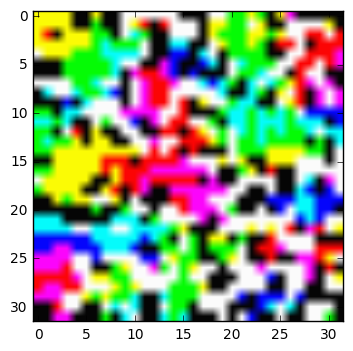

In [34]:
plt.imshow(Image.fromarray((perturbation[0]*10).astype('uint8'),'RGB'))

## Image + Perturbation

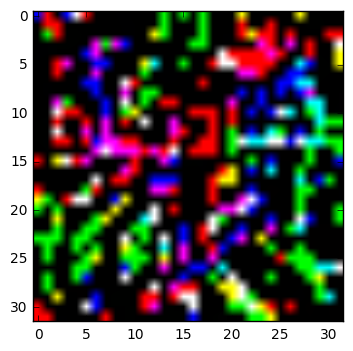

In [35]:
plt.imshow(Image.fromarray(adv[0].astype('uint8'),'RGB'))

In [36]:
model.predict(adv).argmax()

9

In [37]:
model.predict(x_train[0][np.newaxis,:,:]).argmax()

6

In [195]:
model.evaluate(x_train, y_train)

49888/50000 [============================>.] - ETA: 0s

[9.8204741006469725, 0.38890000000000002]

In [174]:
from cifar_keras_vgg import VGG
import pandas as pd

In [4]:
vgg = VGG(32,32,3)

In [5]:
x_train, y_train, x_test,y_test = vgg.load_cifar10()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


In [35]:
numbers = [x.argmax() for x in y_train]

In [41]:
np.unique(numbers, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

In [50]:
number_of_values_to_remove = 2500

In [51]:
class_number = 6

In [52]:
indexes = []

In [53]:
for ix in range(len(numbers)):
    if number_of_values_to_remove > 0:
        if numbers[ix] == class_number:
            indexes.append(ix)
            number_of_values_to_remove = number_of_values_to_remove - 1

In [54]:
len(np.delete(numbers, indexes))

47500